In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex

In [2]:
import pynrc
# Link to Pysnyphot
S = pynrc.nrc_utils.S

from astropy.io import ascii

## Grism Saturation Limits

In [3]:
# Initiate NIRCam observation
pynrc.setup_logging('WARN', verbose=False)
nrc = pynrc.NIRCam('F322W2', pupil='GRISM0', wind_mode='STRIPE', ngroup=2, ypix=64, module='A')

# Want to know K-Band limiting magnitude
#bp_k = S.ObsBandpass('johnson,k')
ks = ascii.read("2mass_ks.txt", data_start=0)
bp_k = S.ArrayBandpass(ks['col1']*1e4, ks['col2'], name='Ks-Band')

# Spectral types to check
sp_A0V = pynrc.stellar_spectrum('A0V')
sp_M2V = pynrc.stellar_spectrum('M2V')

# Check ramp settings and times
#ramp_settings = nrc.multiaccum.to_dict(verbose=True)
#ramp_times = nrc.Detectors[0].times_to_dict(verbose=True)

In [4]:
# F322W Saturation limits
nrc.filter = 'F322W2'
sat_F322W_A0V = nrc.sat_limits(sp_A0V, bp_k)
sat_F322W_M2V = nrc.sat_limits(sp_M2V, bp_k)

In [5]:
# F444W Saturation limits
nrc.filter = 'F444W'
sat_F444W_A0V = nrc.sat_limits(sp_A0V, bp_k)
sat_F444W_M2V = nrc.sat_limits(sp_M2V, bp_k)

In [6]:
# Wavelengths to interoplate
waves3 = np.arange(2.5,4.1,0.2) # F322W2
waves4 = np.arange(4.1,5.1,0.2) # F444W
waves = np.concatenate((waves3,waves4))

# Interpolate above results and combine
sat3 = np.interp(waves3,sat_F322W_A0V['wave'],sat_F322W_A0V['satmag'])
sat4 = np.interp(waves4,sat_F444W_A0V['wave'],sat_F444W_A0V['satmag'])
sat_A0V = np.concatenate((sat3,sat4))

sat3 = np.interp(waves3,sat_F322W_M2V['wave'],sat_F322W_M2V['satmag'])
sat4 = np.interp(waves4,sat_F444W_M2V['wave'],sat_F444W_M2V['satmag'])
sat_M2V = np.concatenate((sat3,sat4))

## Continuum Sensitivities

In [7]:
flist = ['F277W', 'F356W', 'F444W', 'F322W2', 'F430M', 'F460M']

# Zodiacal Background Rates
print('{:<8} {:<6} {:<6} {:<6} {:<6} {:<6}'.format('Filter', 'Low', 'NRC', 'Avg', 'High', 'Max'))
for filt in flist:
    nrc.filter = filt
    print('{:<8} {:<6.2f} {:<6.2f} {:<6.2f} {:<6.2f} {:<6.2f}'
        .format(nrc.filter, nrc.bg_zodi(1), nrc.bg_zodi(1.2), \
                nrc.bg_zodi(2.5), nrc.bg_zodi(5), nrc.bg_zodi(10)))

Filter   Low    NRC    Avg    High   Max   
F277W    0.08   0.10   0.20   0.40   0.79  
F356W    0.14   0.17   0.35   0.69   1.38  
F444W    0.39   0.47   0.98   1.95   3.90  
F322W2   0.23   0.27   0.57   1.14   2.27  
F430M    0.07   0.09   0.18   0.36   0.71  
F460M    0.09   0.11   0.23   0.46   0.92  


In [8]:
# Continuum sensitivity (10-sigma at 10000-sec)
#nrc.update_detectors(wind_mode='FULL', ngroup=93, nint=10, ypix=2048, verbose=True)
nrc.update_detectors(wind_mode='FULL', read_mode='DEEP8', ngroup=10, nint=5, ypix=2048, verbose=True)

nrc.filter = 'F444W'
sens_F444W = nrc.sensitivity(nsig=10, zfact=2.5)

nrc.filter='F322W2'
sens_F322W = nrc.sensitivity(nsig=10, zfact=2.5)

sen3 = np.interp(waves3,sens_F322W['wave'],sens_F322W['sensitivity'])
sen4 = np.interp(waves4,sens_F444W['wave'],sens_F444W['sensitivity'])
sen_cont = np.concatenate((sen3,sen4))

New Ramp Settings:
  read_mode :    DEEP8
  nf        :        8
  nd2       :       12
  ngroup    :       10
  nint      :        5
New Detector Settings
  wind_mode :     FULL
  xpix      :     2048
  ypix      :     2048
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :  214.735
  t_frame   :   10.737
  t_int     : 2018.513
  t_exp     : 10092.564
  t_acq     : 10146.248


## Grism Resolution

In [9]:
import multiprocessing as mp

#waves = np.arange(2,6.1,0.1)

webbpsf = pynrc.nrc_utils.webbpsf
inst = webbpsf.NIRCam()
inst.options['output_mode'] = 'both'
inst.options['parity'] = 'even'
inst.pupilopd = None #('OPD_RevV_nircam_136.fits', 0)
inst.filter = nrc.filter
inst.image_mask = None
# WebbPSF doesn't know about the grisms, so set pupil=None, otherwise inst_params['pupil']
inst.pupil_mask = None

inst.SHORT_WAVELENGTH_MIN = inst.LONG_WAVELENGTH_MIN = 0
inst.SHORT_WAVELENGTH_MAX = inst.LONG_WAVELENGTH_MAX = 10e-6

In [10]:
def wrap_psf_for_mp(args):
    """
    Internal helper routine for parallelizing computations across multiple processors.
    """
    inst,w,fov_pix,oversample = args
    hdu_list = inst.calcPSF(outfile=None, save_intermediates=False, oversample=oversample, rebin=True, \
                            fov_pixels=fov_pix, monochromatic=w*1e-6, display=False, normalize='last')

    # Original data
    data0 = hdu_list[0].data
    data1 = hdu_list[1].data

    # Scale oversampled data via rebin, then downsample to detector pixels
    data0_scale = pynrc.nrc_utils.frebin(data0, scale=(1,1.07))
    data0_scale = pynrc.nrc_utils.pad_or_cut_to_size(data0_scale, data0.shape)
    data1_scale = pynrc.nrc_utils.frebin(data0_scale, dimensions=data1.shape)
    
    hdu_list[0].data = data0_scale
    hdu_list[1].data = data1_scale

    # Oversampled PSF
    fwhm_pix = webbpsf.measure_fwhm(hdu_list,0) / hdu_list[0].header['PIXELSCL']
    fwhm_over = fwhm_pix / hdu_list[0].header['OVERSAMP ']
    # Detector Sampled
    fwhm_det = webbpsf.measure_fwhm(hdu_list,1) / hdu_list[1].header['PIXELSCL']
    # Diffraction Limit
    fwhm_dif = hdu_list[1].header['DIFFLMT'] / hdu_list[1].header['PIXELSCL']

    return (fwhm_over,fwhm_det,fwhm_dif)

In [11]:
nproc = 16
npsf = waves.size
nproc = np.min([nproc, npsf])
np_max = np.ceil(npsf / nproc)
nproc = int(np.ceil(npsf / np_max))
#print(nproc)

fwhm_over_all = []
fwhm_det_all = []
fwhm_dif_all = []
os_arr = [60,61]


for os in os_arr:
    fov_pix = 16
    oversample = os

    pool = mp.Pool(nproc)
    worker_arguments = [(inst, wlen, fov_pix, oversample) for wlen in waves]
    results = pool.map(wrap_psf_for_mp, worker_arguments)
    pool.close()
    
    results = np.array(results)
    fwhm_over_all.append(results[:,0])
    fwhm_det_all.append(results[:,1])
    fwhm_dif_all.append(results[:,2])

# Oversampled
test = np.array(fwhm_over_all)
fwhm_mean = test.mean(axis=0)
z = np.polyfit(waves, fwhm_mean, 3)
pfit = np.poly1d(z)
fwhm_over = pfit(waves)

# Detector Sampled
test = np.array(fwhm_det_all)
fwhm_mean = test.mean(axis=0)
z = np.polyfit(waves, fwhm_mean, 3)
pfit = np.poly1d(z)
fwhm_det = pfit(waves)

# Diffraction Limit
test = np.array(fwhm_dif_all)
fwhm_mean = test.mean(axis=0)
z = np.polyfit(waves, fwhm_mean, 3)
pfit = np.poly1d(z)
fwhm_dif = pfit(waves)

1786.93927887 1672.32494583 2012.10478132


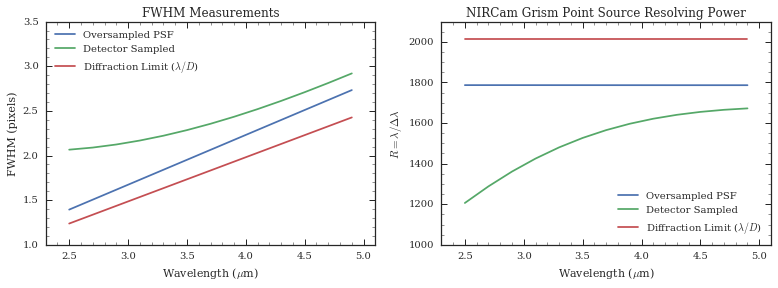

In [12]:
#res = 996.48
#disp = 0.0010035
#res = 1 / disp
res, dw = pynrc.nrc_utils.grism_res(nrc.pupil,nrc.module)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

#for i in range(len(os_arr)):
#    ax1.plot(waves, fwhm_pix_all[i], label ='Oversample=%i'%(os_arr[i]))
ax1.plot(waves, fwhm_over, label='Oversampled PSF')
ax1.plot(waves, fwhm_det,  label='Detector Sampled')
ax1.plot(waves, fwhm_dif,  label='Diffraction Limit ($\lambda/D$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('FWHM (pixels)')
ax1.set_title('FWHM Measurements')
ax1.legend(loc='best')
ax1.set_xlim([2.3,5.1])
ax1.set_ylim([1.0,3.5])
ax1.minorticks_on()

R_over = waves*res/fwhm_over
R_det = waves*res/fwhm_det
R_dif = waves*res/fwhm_dif

#for i in range(len(os_arr)):
#    d_lambda = fwhm_pix_all[i]
#    ax2.plot(waves, waves*res/d_lambda, label ='Oversample=%i'%(os_arr[i]))
ax2.plot(waves, R_over, label='Oversampled PSF')
ax2.plot(waves, R_det,  label='Detector Sampled')
ax2.plot(waves, R_dif,  label='Diffraction Limit ($\lambda/D$)')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_ylabel('$R=\lambda/\Delta\lambda$')
ax2.set_title('NIRCam Grism Point Source Resolving Power')
ax2.legend(loc='best')
ax2.set_xlim([2.3,5.1])
ax2.set_ylim([1000,2100])
ax2.minorticks_on()

print(R_over.max(),R_det.max(),R_dif.max())

In [13]:
#from astropy.table import Table
#data = [waves, fwhm_det, fwhm_over, R_det, R_over]
#names = ['Wavelength', 'FWHM_det', 'FWHM_over', 'Res_det', 'Res_over']
#tbl = Table(data, names=names)
#tbl.write('table.dat', format='ascii')

## Unresolved Line Sensitivities

In [14]:
# F_line[W/m^2] = 3e-18 * F_cont[uJy] / (wave[um] * R) 
sen_line = 3e-18 * sen_cont / (waves * R_det) 

## Final values

In [15]:
arr = np.array([waves,R_det,sen_cont,sen_line,sat_A0V,sat_M2V]).T
matrix = arr.tolist()
print('{:<7}{:<10}{:<7}{:<10}{:<7}{:<7}'.format('Wave','Res','Fcont','Fline','K_A0V','K_M2V'))
for row in matrix:
    print('{:<7.1f}{:<10.2f}{:<7.2f}{:<10.2e}{:<7.2f}{:<7.2f}'.format(*tuple(row)))


Wave   Res       Fcont  Fline     K_A0V  K_M2V  
2.5    1206.11   9.04   8.99e-21  4.23   4.19   
2.7    1287.87   6.75   5.82e-21  4.38   4.35   
2.9    1360.90   6.00   4.56e-21  4.31   4.31   
3.1    1424.93   6.49   4.41e-21  4.07   4.12   
3.3    1480.06   5.18   3.18e-21  4.12   4.27   
3.5    1526.63   5.10   2.86e-21  3.98   4.19   
3.7    1565.22   5.02   2.60e-21  3.87   4.08   
3.9    1596.54   5.42   2.61e-21  3.66   3.90   
4.1    1621.39   7.63   3.44e-21  3.40   3.64   
4.3    1640.59   8.52   3.62e-21  3.14   3.39   
4.5    1654.97   9.95   4.01e-21  2.87   3.00   
4.7    1665.31   12.59  4.83e-21  2.45   2.72   
4.9    1672.32   16.62  6.09e-21  2.10   2.36   
